In [3]:
import pandas as pd
import numpy as np
from pynm.pynm import PyNM
import seaborn as sns
import matplotlib.pyplot as plt

import patsy as pat
import statsmodels.api as sm

This notebook is an introduction to normative modeling and demonstrates basic API usage of PyNM.

## **Generate data**

In [378]:
def model(age, sex, offset):
    noise = np.random.normal(0, 0.1)
    return 0.001*age-0.00001*(age-50)**2*(age-45)**2 + 2.5 + noise - np.random.uniform(0, 0.3) * sex + offset


def model_prob(age, sex, offset):
    noise = np.random.normal(0, 0.1)
    return 0.001*age-0.00001*(age-50)**2*(age-45)**2 + 2.5 + 2*noise - np.random.uniform(0, 0.3) * sex + 0.2 *np.random.uniform() + offset

def generate_data(group='PROB_CON', sample_size=1, n_sites=2, randseed=3):
    np.random.seed(randseed)
    n_sites = n_sites
    age_min = (np.random.rand(n_sites)*50).astype(int)
    sites = pd.DataFrame(data={'sex_ratio': np.random.rand(n_sites),
                               'prob_ratio': 0.5*np.random.rand(n_sites),
                               'age_min': age_min,
                               'age_max': (age_min+5+np.random.rand(n_sites)*50).astype(int),
                               'score_shift': np.random.randn(n_sites)/4,
                               'sample_size': (sample_size+np.random.rand(n_sites)*sample_size*10).astype(int)})

    participants = []
    for site in sites.iterrows():
        for participant in range(int(site[1]['sample_size'])):
            sex = np.random.binomial(1, site[1]['sex_ratio'])
            prob = np.random.binomial(1, site[1]['prob_ratio'])
            age = np.random.uniform(site[1]['age_min'], site[1]['age_max'])
            if prob:
                score = model_prob(age, sex, site[1]['score_shift'])
            else:
                score = model(age, sex, site[1]['score_shift'])
            participants.append([site[0], sex, prob, age, score])

    df = pd.DataFrame(participants, columns=['site', 'sex', 'group', 'age', 'score'])
    df.sex.replace({1: 'Female', 0: 'Male'}, inplace=True)
    if group == 'PROB_CON':
        df.group.replace({1: 'PROB', 0: 'CTR'}, inplace=True)
    return df

In [379]:
df = generate_data(n_sites=1,sample_size=50,randseed=500)
print('n subjects = {}'.format(df.shape[0]))

n subjects = 298


## **Visualize data**

### By PROB vs CTR

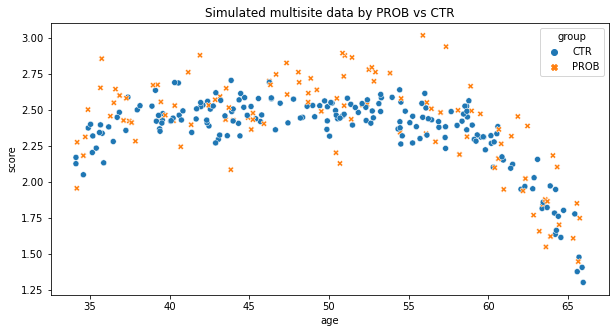

In [380]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='age', y='score', hue='group', style='group')
plt.title('Simulated multisite data by PROB vs CTR')
plt.show()

## **PyNM - Normative Modeling**

In [381]:
#Initialize pynm w/ data and confounds
m = PyNM(df,'score','group',
        conf = 'age',                           #confound for LOESS and Centiles model
        confounds = ['age'])                    #confound for GP model

Fitting model on full set of controls...


In [382]:
#Run models
loess = m.loess_normative_model()
centiles = m.centiles_normative_model()
gp = m.gp_normative_model()

#Collect output
data = m.data

## **Visualize Normative Models**

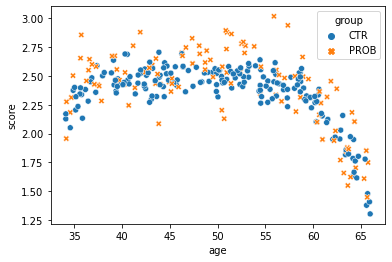

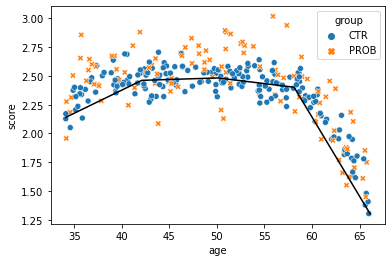

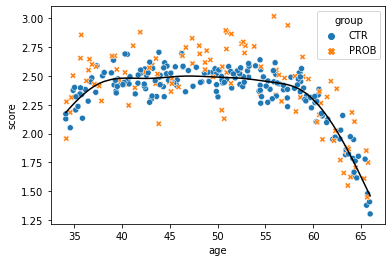

In [383]:
m.plot(plot_type='centiles')
m.plot(plot_type='LOESS')
m.plot(plot_type='GP')

## **Corrected scores**
Using GP model (age, sex, site confounds)

Text(0.5, 1.0, 'Corrected')

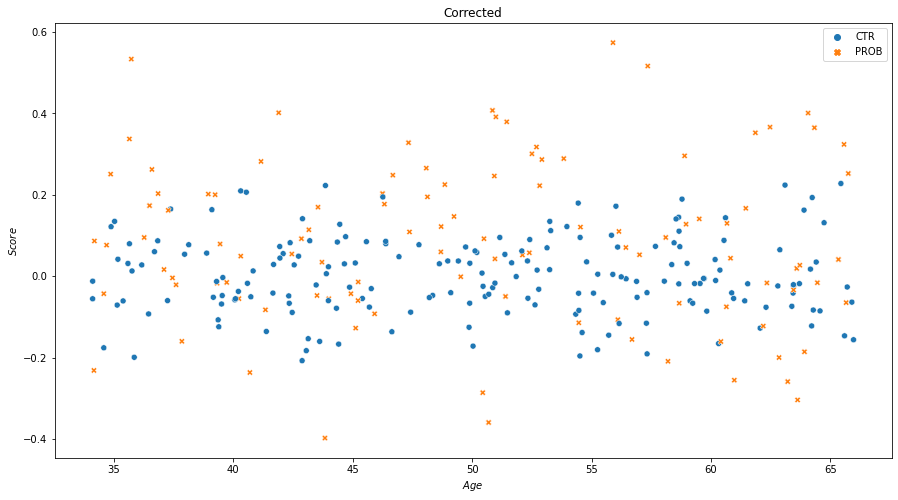

In [384]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=data,x='age', y='GP_nmodel_residuals',hue='group',style='group')

plt.xlabel('$Age$')
plt.ylabel('$Score$')
plt.legend(loc='upper right')
plt.title('Corrected')

Text(0.5, 1.0, 'Uncorrected')

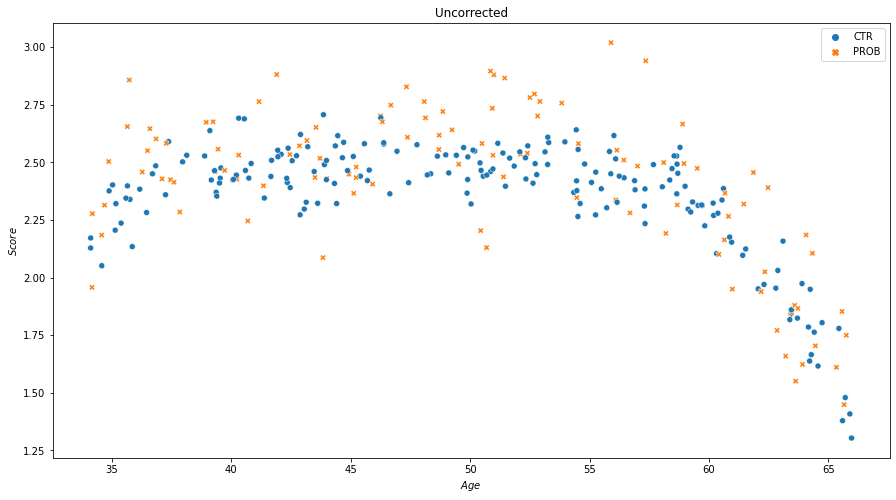

In [385]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=data,x='age', y='score',hue='group',style='group')

plt.xlabel('$Age$')
plt.ylabel('$Score$')
plt.legend(loc='upper right')
plt.title('Uncorrected')

## **Case-control**
Corrected vs uncorrected scores

In [386]:
dmat = pat.dmatrix('C(group)', m.data, return_type='dataframe',NA_action='raise')
    
mod = sm.OLS(m.data['score'],dmat)
results = mod.fit()

print('Uncorrected')
print('p-val case-control difference: ',np.round(results.pvalues[1],5))

Uncorrected
p-val case-control difference:  0.10692


In [387]:
mod = sm.OLS(m.data['GP_nmodel_residuals'],dmat)
results = mod.fit()

print('Corrected')
print('p-val case-control difference: ',results.pvalues[1])

Corrected
p-val case-control difference:  2.1582771779097835e-06
